In [ ]:
from ethereum_block_explorer.core import get_txs_blocks_mempool, filter_from_address
import datetime
import jupyter_black
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")
jupyter_black.load()

In [ ]:
txs = pl.scan_parquet("transactions/*.parquet")
blocks = pl.scan_parquet("blocks/*.parquet")
mempool = pl.scan_parquet("data/transaction-data/*.parquet")

In [ ]:
# Arbitrum: Batch Submitter 0xc1b634853cb333d3ad8663715b08f41a3aec47cc
arbitrum_batch_submitter_address = "0xc1b634853cb333d3ad8663715b08f41a3aec47cc"

In [ ]:
txs_blocks_mempool = get_txs_blocks_mempool(txs, blocks, mempool)

txs_blocks_mempool = filter_from_address(
    txs_blocks_mempool, arbitrum_batch_submitter_address
)

In [ ]:
ordinal_spam_stats_df = (
    txs_blocks_mempool.group_by("block_number")
    .agg(
        pl.col("block_datetime").first().alias("datetime"),
        (pl.col("base_fee_per_gas").first() / 10**9).alias("base_fee_per_gas_gwei"),
        pl.col("gas_used_block").first().alias("block_gas_used"),
        pl.col("gas_used").sum().alias("sequencer_gas_used_sum"),
        pl.col("transaction_index_max").first().alias("block_tx_size"),
        pl.count().alias("sequencer_tx_count"),
    )
    .with_columns(
        (pl.col("sequencer_gas_used_sum") / pl.col("block_gas_used")).alias(
            "seq_gas_block_percent"
        ),
        (pl.col("sequencer_tx_count") / pl.col("block_tx_size")).alias(
            "seq_tx_block_percent"
        ),
    )
    .sort(by="datetime", descending=True)
    .collect(streaming=True)
)

In [ ]:
# filter ordinal_spam_stats_df for datetime between 2023-12-15 15:29 and 2023-12-15 16:57
ordinal_spam_stats_df.filter(
    pl.col("datetime") > datetime.datetime(2023, 12, 15, 15, 29)
).filter(pl.col("datetime") < datetime.datetime(2023, 12, 15, 16, 57)).sort(
    by="sequencer_gas_used_sum", descending=True
).sort(
    by="block_number"
).head(
    5
)

block_number,datetime,base_fee_per_gas_gwei,block_gas_used,sequencer_gas_used_sum,block_tx_size,sequencer_tx_count,seq_gas_block_percent,seq_tx_block_percent
u32,datetime[μs],f64,u64,u64,u64,u32,f64,f64
18792413,2023-12-15 15:29:11,119.768635407,20863097,10529448,195,6,0.50469247207162,0.03076923076923077
18792414,2023-12-15 15:29:23,125.620428131,18071352,8651717,90,5,0.478753166890889,0.05555555555555555
18792415,2023-12-15 15:29:35,128.83563274,14604953,5291864,142,3,0.3623335179510677,0.02112676056338028
18792417,2023-12-15 15:29:59,118.97374437,11895868,1740539,141,1,0.14631458587132945,0.0070921985815602835
18792425,2023-12-15 15:31:35,95.726746751,15079670,1738687,159,1,0.11530006956385651,0.006289308176100629


On Ethereum, a block's max gas limit was changed from 15m to 30m as a [result of EIP-1559](https://decentralizedthoughts.github.io/2022-03-10-eip1559/). EIP-1559 targetes a 15m limt. With EIP-1559, the base fee will increase and decrease by up to 12.5% after blocks are more than 50% full. For example, if a block is 100% full the base fee increases by 12.5%; if it is 50% full the base fee will be the same; if it is 0% full the base fee would decrease by 12.5% [(source, consensys)](https://consensys.io/blog/what-is-eip-1559-how-will-it-change-ethereum). 

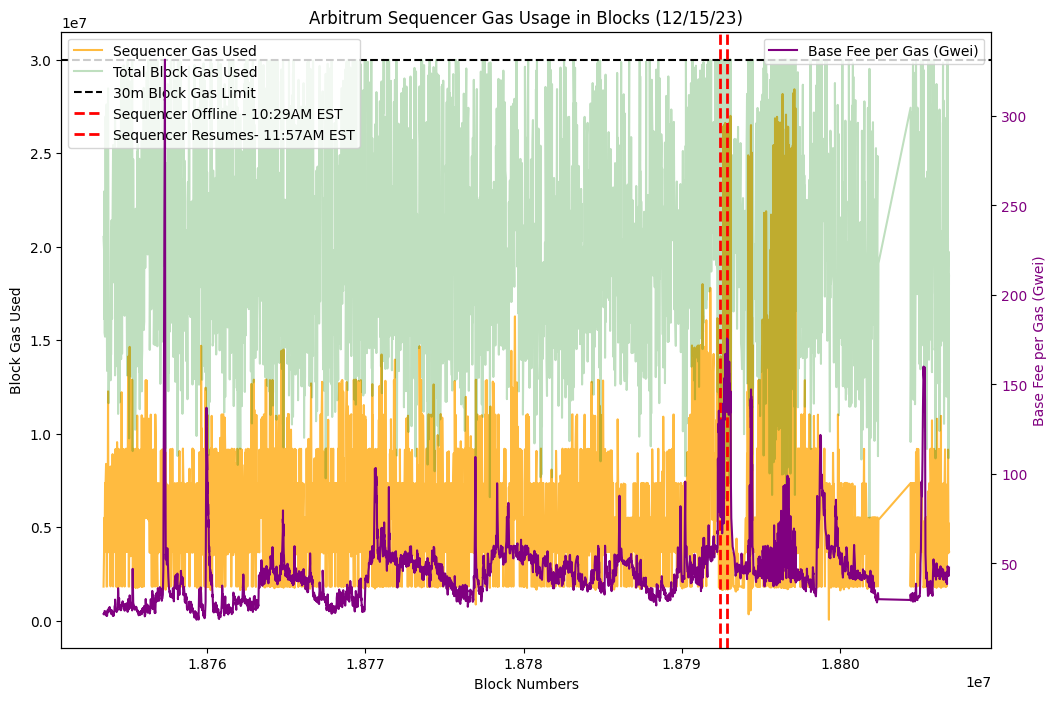

In [ ]:
# Convert to pandas DataFrame (if not already)
plot_df = ordinal_spam_stats_df.to_pandas()

# Create a single plot with dual y-axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot 'sequencer_gas_used_sum' and 'block_gas_used' on the first y-axis
ax1.plot(
    plot_df["block_number"],
    plot_df["sequencer_gas_used_sum"],
    label="Sequencer Gas Used",
    color="orange",
    alpha=0.75,
)
ax1.plot(
    plot_df["block_number"],
    plot_df["block_gas_used"],
    label="Total Block Gas Used",
    color="green",
    alpha=0.25,
)
ax1.axhline(y=3e7, color="black", linestyle="--", label="30m Block Gas Limit")
ax1.set_xlabel("Block Numbers")
ax1.set_ylabel("Block Gas Used", color="black")
ax1.tick_params(axis="y", labelcolor="black")

# vertical lines where arbitrum sequencer was offline
ax1.axvline(
    x=18792413,
    color="red",
    linestyle="--",
    lw=2,
    label="Sequencer Offline - 10:29AM EST",
)
ax1.axvline(
    x=18792845,
    color="red",
    linestyle="--",
    lw=2,
    label="Sequencer Resumes- 11:57AM EST",
)
ax1.legend(loc="upper left")

# Create a twin y-axis for 'base_fee_per_gas_gwei'
ax2 = ax1.twinx()
ax2.plot(
    plot_df["block_number"],
    plot_df["base_fee_per_gas_gwei"],
    label="Base Fee per Gas (Gwei)",
    color="purple",
)
ax2.set_ylabel("Base Fee per Gas (Gwei)", color="purple")
ax2.tick_params(axis="y", labelcolor="purple")
ax2.legend(loc="upper right")


# Title
plt.title("Arbitrum Sequencer Gas Usage in Blocks (12/15/23)")

# Show the plot
plt.show()